In [2]:
import keras
from keras.layers import Input, Conv2D, Flatten, MaxPool2D, Dropout, Dense, LSTM, GRU, Conv1D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from keras import models
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
import cv2
import time
import glob, os 
from skimage import io, transform
import json

Using TensorFlow backend.


## Problem 2

For this problem you use the data in “admData.csv” on Canvas. This file contains the accumulative number of admitted students to a certain program with 5 annual start dates.

The data has seasonal behavior: the accumulative number of admissions is monotonically increasing during the interval between 2 start dates and then it resets once a new term starts as shown in figure 1.

The objective of the problem is to predict the accumulative number of admissions 7, 14, 21, 28, 35, 42, 49, 56, 63, and 70 days from the current date.

![Figure 1](Figure1.png)

i.e. on any given day, you need to forecast what the accumulative number of admissions will be in 1 week, 2 weeks, ... 10 weeks from that day.
You need to use 70% of the data for training, 15% for validation, and 15% (the most recent) for test.

## 1

Create a recurrent neural network model. Explore both GRU and LSTM layers.

---

### Reading the Data

So here, we separate the year, month, and day of the date.

In [15]:
df = pd.read_csv(
    filepath_or_buffer="admData.csv"
)
df["month"] = df['InquiryDate'].astype(str).str.split("/").str[0].astype(int)
df["day"] = df['InquiryDate'].astype(str).str.split("/").str[1].astype(int)
df["year"] = df['InquiryDate'].astype(str).str.split("/").str[2].astype(int)
dates = df['InquiryDate'].tolist()
df['InquiryDate'] = pd.to_datetime(df['InquiryDate'])
df.head()

,InquiryDate,DailyAdmission,month,day,year
0,2017-08-22,41,8,22,2017
1,2017-08-23,47,8,23,2017
2,2017-08-24,56,8,24,2017
3,2017-08-25,63,8,25,2017
4,2017-08-26,70,8,26,2017


### Feature Extraction

Based on a number of days to look back, we can add additional columns based on the "Daily Admission" those number of days looking back. We must note that the largest of the number of the days looking back reduces our dataset.

In [14]:
days = [3, 1, 9, 5]

def get_features_by_days(df, days):
    days.sort()
    _tmp_df = df
    for num_days_back in days:
        _tmp = [None] * num_days_back
        _tmp.extend(df.iloc[:-num_days_back, :]["DailyAdmission"].values.tolist())
        _tmp_df["{}DaysBack".format(num_days_back)] = _tmp
    _tmp_df = _tmp_df.dropna()
    cols = _tmp_df.columns.tolist()
    return _tmp_df[cols[1:] + [cols[0]]]
get_features_by_days(df, days).head()

,DailyAdmission,month,day,year,1DaysBack,3DaysBack,5DaysBack,9DaysBack,DaysInYear_shift,InquiryDate
9,92,8,31,2017,86.0,73.0,70.0,41.0,248,2017-08-31
10,94,9,1,2017,92.0,77.0,70.0,47.0,249,2017-09-01
11,94,9,2,2017,94.0,86.0,73.0,56.0,250,2017-09-02
12,94,9,3,2017,94.0,92.0,77.0,63.0,251,2017-09-03
13,94,9,4,2017,94.0,94.0,86.0,70.0,252,2017-09-04


Now, let's look at the dramatic decreases we have in the training dataset.

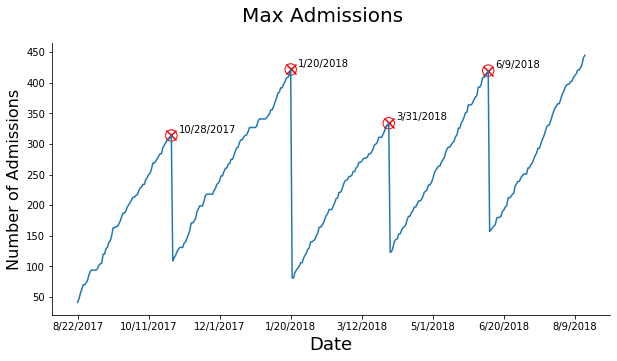

In [7]:
peaks = [66, 150, 219, 289]

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(range(df["DailyAdmission"].shape[0]), df["DailyAdmission"])
plt.scatter(df.iloc[peaks, :].index.tolist(), df.iloc[peaks, :]["DailyAdmission"].tolist(), s=100, c="red", marker="x")
plt.scatter(df.iloc[peaks, :].index.tolist(), df.iloc[peaks, :]["DailyAdmission"].tolist(), s=130, facecolors='none', edgecolors='r')
[plt.text(_labels[0]+5, _labels[1]+5, _labels[2], fontsize=10) for _labels in list(zip(
    df.iloc[peaks, :].index.tolist(), 
    df.iloc[peaks, :]["DailyAdmission"].tolist(), 
    (df.iloc[peaks, :]["month"].astype(str) + "/" + df.iloc[peaks, :]["day"].astype(str) + "/" + df.iloc[peaks, :]["year"].astype(str)).tolist()
))]
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
_tmp = [labels[0]]
labels = labels[1:]
_tmp.extend([dates[int(label)] for label in labels if not label[0] == "−" and int(label) < len(dates)])
ax.set_xticklabels(_tmp)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
fig.suptitle('Max Admissions', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Admissions', fontsize=16)
plt.show()

So we can see that there are definite peaks in the time series. While the first and last recordings are 8/22/2017 and 8/16/2018 respectively, we can assume that the next peak will be half-way between those dates minus the year: 8/18. In other words, the number of admissions will drastically decrease after these days:
 - 1/20
 - 3/31
 - 6/9
 - 8/18
 - 10/28

So after looking at all the peaks comparatively with the data, we see that the first peak in the year is Jan 20. Let's 

In [17]:
# Jan 1 is df.iloc[131,:]
df["DaysInYear"] = df['InquiryDate'].map(lambda x: x.month*31 + x.day - 31)
df.head()

,InquiryDate,DailyAdmission,month,day,year,DaysInYear_shift,DaysInYear
0,2017-08-22,41,8,22,2017,239,239
1,2017-08-23,47,8,23,2017,240,240
2,2017-08-24,56,8,24,2017,241,241
3,2017-08-25,63,8,25,2017,242,242
4,2017-08-26,70,8,26,2017,243,243


### Partitioning the Data

Here, we set 70% of the data for training, 15% for validation, and the last 15% for testing the data.

In [3]:
train_portion = round(df.shape[0] * 0.7)
validation_portion = round(df.shape[0] * 0.15)
train_data = df[["DailyAdmission"]][0:train_portion].values
validation_data = df[["DailyAdmission"]][train_portion:train_portion+validation_portion].values
test_data = df[["DailyAdmission"]][train_portion+validation_portion:].values

### Normalizing the Data

In [4]:
sc = MinMaxScaler(feature_range=(0,1))
train_data = train_data.reshape(-1,1)
validation_data = validation_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

Here we use the scale factor, `sc`, for re-purposing the data to fit in a range between 0 and 1.

In [5]:
sc.fit(train_data)
norm_train = sc.transform(train_data)
norm_validation = sc.transform(validation_data)
norm_test = sc.transform(test_data)

### Creating Sequences

Here we can use a function to develop sequences to train our model with.

In [6]:
def create_sequence(dataset, look_back=5, foresight=4):
    X, Y = [], []
    for i in range(len(dataset)-look_back-foresight):
        observations = dataset[i:(i+look_back), 0] # Sequence of look back
        X.append(observations)
        Y.append(dataset[i+(look_back+foresight), 0])
    return np.array(X), np.array(Y)

In [16]:
norm_train_x, norm_train_y = create_sequence(norm_train)
norm_validation_x, norm_validation_y = create_sequence(norm_validation)
norm_test_x, norm_test_y = create_sequence(norm_test)
norm_train_x = np.reshape(norm_train_x, (norm_train_x.shape[0],norm_train_x.shape[1],1))
norm_validation_x = np.reshape(norm_validation_x, (norm_validation_x.shape[0],norm_validation_x.shape[1],1))
norm_test_x = np.reshape(norm_test_x, (norm_test_x.shape[0],norm_test_x.shape[1],1))

### LSTM and GRU Models

In [17]:
def create_lstm_gru_model(
    norm_train_x, 
    filter_size=32, 
    dropout=0.1, 
    recurrent_dropout=0.1, 
    lstm=True
):
    model = Sequential()
    if lstm:
        model.add(
            LSTM(
                filter_size, 
                input_shape=(norm_train_x.shape[1],1), 
                dropout=dropout, 
                recurrent_dropout=recurrent_dropout
            )
        )
    else:
        model.add(
            GRU(
                filter_size, 
                input_shape=(norm_train_x.shape[1],1), 
                dropout=dropout, 
                recurrent_dropout=recurrent_dropout
            )
        )
    model.add(
        Dense(
            1, 
            activation="linear"
        )
    )
    model.compile(
        loss="mae", 
        optimizer="adam",
        metrics=["mean_absolute_error"]
    )
    return model

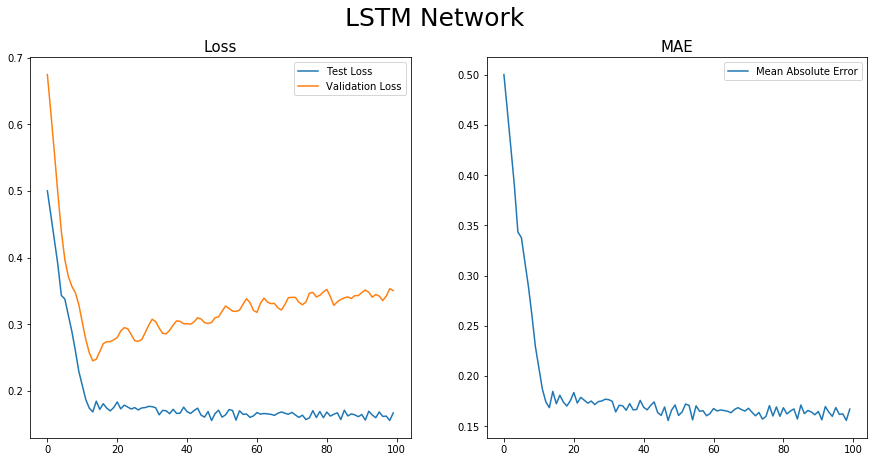

In [33]:
model = create_lstm_gru_model(
    norm_train_x, 
    filter_size=32, 
    dropout=0.9, 
    recurrent_dropout=0.3, 
    lstm=True
)
history = model.fit(
    norm_train_x, 
    norm_train_y,
    validation_data=(
        norm_validation_x,
        norm_validation_y
    ),
    epochs=100,
    batch_size=64,
    callbacks=[],
    verbose=0
)
fig = plt.figure(figsize=(15,7))
fig.suptitle("LSTM Network", fontsize=25)
plt.subplot(1,2,1)
plt.title("Loss", fontsize=15)
plt.plot(history.history["loss"], label="Test Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1,2,2)
plt.title("MAE", fontsize=15)
plt.plot(history.history["mean_absolute_error"], label="Mean Absolute Error")
plt.legend()
plt.show()

### 1D CONV Models

In [22]:
def create_conv_model(
    norm_train_x, 
    filter_size=32, 
    dropout=0.1, 
    recurrent_dropout=0.1,
    kernel_size=3,
    lstm=True
):
    model = Sequential()
    model.add(
        Conv1D(
            filter_size,
            input_shape=(norm_test_x.shape[1],1),
            kernel_size=kernel_size,
            padding="same"
        )
    )
    if lstm:
        model.add(
            LSTM(
                filter_size, 
                input_shape=(norm_train_x.shape[1],1), 
                dropout=dropout, 
                recurrent_dropout=recurrent_dropout
            )
        )
    else:
        model.add(
            GRU(
                filter_size, 
                input_shape=(norm_train_x.shape[1],1), 
                dropout=dropout, 
                recurrent_dropout=recurrent_dropout
            )
        )
    model.add(
        Dense(
            1, 
            activation="linear"
        )
    )
    model.compile(
        loss="mae", 
        optimizer="adam",
        metrics=["mean_absolute_error"]
    )
    return model

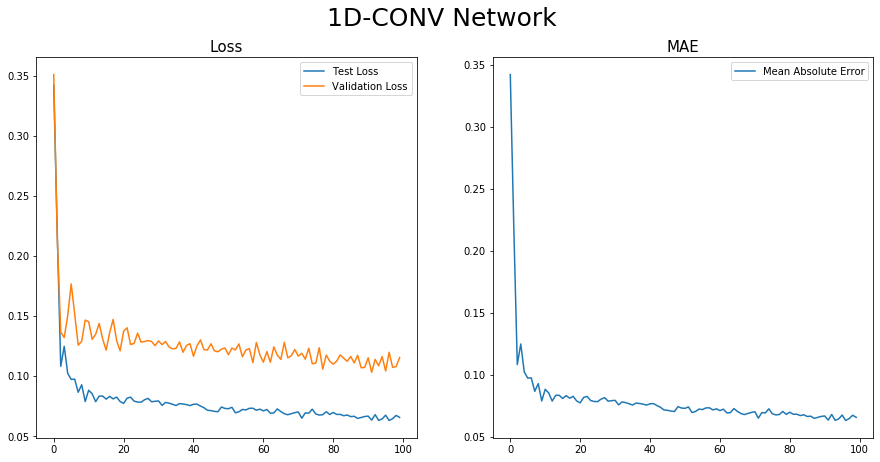

In [34]:
model = create_conv_model(
    norm_train_x, 
    filter_size=32, 
    dropout=0.1, 
    recurrent_dropout=0.1, 
    lstm=True
)
history = model.fit(
    norm_train_x, 
    norm_train_y,
    validation_data=(
        norm_validation_x,
        norm_validation_y
    ),
    epochs=100,
    batch_size=64,
    callbacks=[],
    verbose=0
)
fig = plt.figure(figsize=(15,7))
fig.suptitle("1D-CONV Network", fontsize=25)
plt.subplot(1,2,1)
plt.title("Loss", fontsize=15)
plt.plot(history.history["loss"], label="Test Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1,2,2)
plt.title("MAE", fontsize=15)
plt.plot(history.history["mean_absolute_error"], label="Mean Absolute Error")
plt.legend()
plt.show()